# Домашнє завдання – Заняття 3: Розробка та навчання нейронної мережі

## Мета
Розробити та навчити нейронну мережу для класифікації або регресії на новому наборі даних, використовуючи методи регуляризації для покращення продуктивності моделі та запобігання перенавчанню.

---

## Кроки для виконання завдання

### 1. Завантаження та попередня обробка даних
- Завантажте набір даних і перевірте його на:
  - Пропущені значення.
  - Аномалії.
  - Некоректні типи даних.
- Виконайте нормалізацію або стандартизацію числових ознак.
- Розділіть дані на:
  - Навчальну вибірку.
  - Тестову вибірку.
  - (За необхідності) Валідаційну вибірку для налаштування гіперпараметрів.

---

### 2. Створення архітектури нейронної мережі
- Розробіть архітектуру з кількома прихованими шарами, використовуючи функцію активації ReLU або іншу, залежно від задачі.
- Налаштуйте вихідний шар:
  - Для класифікації: softmax або sigmoid.
  - Для регресії: один нейрон із лінійною активацією.

---

### 3. Додавання методів регуляризації
- **L2 регуляризація:** Додайте штрафні коефіцієнти до ваг моделі для запобігання перенавчанню.
- **Dropout:** Використовуйте між прихованими шарами для випадкового вимикання нейронів під час навчання.
- **Batch Normalization:** Застосуйте для покращення збіжності та стабільності роботи моделі.

---

### 4. Налаштування параметрів навчання
- Використовуйте оптимальні значення гіперпараметрів, отримані в попередніх завданнях.

---

### 5. Навчання моделі з регуляризацією
- Зосередьтеся на уникненні перенавчання, спостерігаючи за результатами на валідаційній вибірці.

---

### 6. Оцінка продуктивності моделі
- Обчисліть метрики точності або середньоквадратичної помилки.
- Перевірте різницю між навчальною та валідаційною вибірками для виявлення перенавчання.
- Побудуйте:
  - Матрицю невідповідностей для класифікації.
  - Графіки оцінки продуктивності для регресійних моделей.

---

### 7. Візуалізація результатів
- Створіть графіки втрат і точності (для класифікації) або середньоквадратичної помилки (для регресії).
- Проаналізуйте вплив регуляризації на покращення роботи моделі.

---

## Мінімальні вимоги
- Реалізувати нейронну мережу та навчити її на новому наборі даних.
- Досягти стабільної роботи моделі із запобіганням перенавчанню через регуляризацію.
- Виконати базову візуалізацію втрат і продуктивності.

---

## Додаткові рекомендації
- Експериментуйте з гіперпараметрами регуляризації, такими як коефіцієнт L2 або ймовірність Dropout.
- Застосуйте **ранню зупинку (Early Stopping)**, щоб уникнути перенавчання.

---

## Формат виконання
- **.ipynb блокнот:** Код із візуалізацією.
- **.py файл:** Код із прикріпленими зображеннями результатів, опублікований на GitHub.


# Підготовка

In [117]:
!pip install tensorboard

In [171]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import random
import inspect
import os


In [172]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
    

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



Files already downloaded and verified
Files already downloaded and verified


# Базові моделі

## З параметризованою регуляризацією



```python
model = BaseModel()
# ...

model.train_model(epochs=10, lr=0.001)  # Без regularization (weight_decay=0.0 за замовчуванням)

model.train_model(epochs=10, lr=0.001, weight_decay=0.01)  # З regularization
```

In [182]:
class BaseNeuralNet(nn.Module):
    def __init__(self, tags= "base/net"):
        super(BaseNeuralNet, self).__init__()
        class_name = self.__class__.__name__
        
        self.writer = None
        self.train_loader = None
        self.test_loader = None
        self.train_dataset = None
        self.test_dataset = None
        self.init_tensorboard(log_dir=f"runs/{class_name}/{tags}")
        self.tags = tags

    # Ініціалізація датасетів
    def init_datasets(self, train_dataset, test_dataset):
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset

    # Ініціалізація лоадерів
    def init_loaders(self, train_loader, test_loader):
        self.train_loader = train_loader
        self.test_loader = test_loader

    # Ініціалізація TensorBoard
    def init_tensorboard(self, log_dir="runs/experiment"):
        self.writer = SummaryWriter(log_dir=log_dir)

    # Закриття TensorBoard
    def close_tensorboard(self):
        if self.writer:
            self.writer.close()

    # Візуалізація втрат
    def plot_losses(self, train_losses, test_losses):
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.legend()
        plt.title('Train and Test Loss')
        plt.show()
        
    def build_path(self, version=1):
        class_name = self.__class__.__name__
        tag_path = self.tags.replace('/', '-')
        
        return f"models/{class_name}__{tag_path}__v{version}.pth"
        
    def save_model(self, version=1):
        save_path = self.build_path(version=version)
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        torch.save(self.state_dict(), save_path)
        print(f"Model saved to {save_path}")
        
    def load_model(self, version=1):
        load_path = self.build_path(version=version)
        if torch.cuda.is_available():
            self.load_state_dict(torch.load(load_path))
        else:
            self.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))
        print(f"Model loaded from {load_path}")

    # Візуалізація прикладів
    def show_predictions(self):
        self.eval()
        examples = iter(self.test_loader)
        images, labels = next(examples)

        with torch.no_grad():
            outputs = self(images)
            _, predictions = torch.max(outputs, 1)

        fig, axes = plt.subplots(1, 5, figsize=(15, 4))
        for i in range(5):
            index = random.randint(0, len(images) - 1)
            axes[i].imshow(images[index].permute(1, 2, 0))  # CIFAR-10 має 3 канали
            axes[i].set_title(f"True: {self.train_dataset.classes[labels[index]]}, Pred: {self.train_dataset.classes[predictions[index]]}")
            axes[i].axis('off')

        plt.show()
    
    # For PRODUCTION USE ONLY    
    def predict(image, model, transform):
        # Перетворюємо зображення через трансформації
        image = transform(image).unsqueeze(0)  # Додаємо batch dimension
        model.eval()
        with torch.no_grad():
            output = model(image)
            _, predicted = torch.max(output, 1)
        return predicted.item()

    # Навчання
    def train_model(self, epochs=10, lr=0.001, weight_decay=0.0, early_stopping_patience=0):
        if self.train_loader is None or self.test_loader is None:
            raise ValueError("Train and test loaders must be initialized before training.")

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        train_losses, test_losses = [], []
        best_loss = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            self.train()
            running_loss = 0.0

            for images, labels in self.train_loader:
                optimizer.zero_grad()
                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            train_loss = running_loss / len(self.train_loader)
            train_losses.append(train_loss)

            self.eval()
            test_loss = 0.0
            correct = 0

            with torch.no_grad():
                for images, labels in self.test_loader:
                    outputs = self(images)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()

            test_loss = test_loss / len(self.test_loader)
            accuracy = correct / len(self.test_dataset)
            test_losses.append(test_loss)
            
            # Рання зупинка
            if early_stopping_patience > 0:
                if test_loss < best_loss:
                    best_loss = test_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= early_stopping_patience:
                        print(f"Early stopping triggered at epoch {epoch + 1}")
                        break

            # Поточне логування
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

            # Логування в TensorBoard
            if self.writer:
                self.writer.add_scalar('Loss/Train', train_loss, epoch)
                self.writer.add_scalar('Loss/Test', test_loss, epoch)
                self.writer.add_scalar('Accuracy', accuracy, epoch)

        # Візуалізація
        self.plot_losses(train_losses, test_losses)
        self.show_predictions()
        self.close_tensorboard()


# Моделі для навчання

## SimpleCIFARNet


In [174]:
class SimpleCIFARNet(BaseNeuralNet):
    def __init__(self, tags):
        super(SimpleCIFARNet, self).__init__(tags)
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # Перетворення зображення в 1D
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x


## CIFARNeuralNetWithDropout

This model, `CIFARNeuralNetWithDropout`, is designed for classifying images from the CIFAR-10 dataset. Here are its key characteristics:

1. **Architecture**: It's a fully connected neural network with three linear layers (fc1, fc2, fc3).

2. **Input Layer**: The input layer (fc1) expects flattened images of size 32x32x3 (3072 neurons), which corresponds to the dimensions of CIFAR-10 images.

3. **Hidden Layers**: 
   - The first hidden layer (fc1) has 512 neurons.
   - The second hidden layer (fc2) has 256 neurons.

4. **Output Layer**: The output layer (fc3) has 10 neurons, corresponding to the 10 classes in CIFAR-10.

5. **Activation Functions**:
   - ReLU (Rectified Linear Unit) is used after the first two linear layers.
   - LogSoftmax is applied to the output layer for multi-class classification.

6. **Regularization**: 
   - Dropout is applied after the first two linear layers to prevent overfitting.
   - The dropout rate is configurable (default is 0.5).

7. **Forward Pass**:
   - The input is first flattened from a 2D image to a 1D vector.
   - The data then passes through the linear layers, with ReLU activations and dropout applied between them.
   - The final output is passed through a LogSoftmax function.

8. **Inheritance**: The model inherits from `BaseNeuralNetWithRegularization`, which likely provides common functionality for training and evaluation.

This model implements several best practices for deep learning:
- Use of dropout for regularization
- ReLU activation functions for non-linearity
- LogSoftmax for stable multi-class classification

It's a relatively simple model designed for the CIFAR-10 dataset, focusing on demonstrating the use of dropout regularization to combat overfitting in neural networks.

In [175]:
class CIFARNeuralNetWithDropout(BaseNeuralNet):
    def __init__(self, tags, p_dropout=0.5):
        super(CIFARNeuralNetWithDropout, self).__init__(tags)
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=p_dropout)  # Регуляризація Dropout
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # Перетворення 2D зображення в 1D
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.softmax(self.fc3(x))
        return x
    

## EnhancedCIFARNet

Description of the `EnhancedCIFARNet` model:

1. **Architecture**: 
   - This is a Convolutional Neural Network (CNN) with three convolutional layers followed by two fully connected layers.
   - It inherits from `BaseNeuralNetWithRegularization`, likely providing common functionality for training and evaluation.

2. **Convolutional Layers**:
   - Conv1: 3 input channels (RGB) to 32 output channels
   - Conv2: 32 input channels to 64 output channels
   - Conv3: 64 input channels to 128 output channels
   - All convolutions use a 3x3 kernel with padding=1 to maintain spatial dimensions

3. **Fully Connected Layers**:
   - FC1: 128 * 4 * 4 (2048) input features to 256 output features
   - FC2: 256 input features to 10 output features (CIFAR-10 classes)

4. **Activation Functions**:
   - ReLU is used after each convolutional and the first fully connected layer
   - LogSoftmax is applied to the final output for multi-class classification

5. **Regularization Techniques**:
   - Dropout: Applied after the first fully connected layer with a configurable rate (default 0.3)
   - Batch Normalization: Applied after each convolutional layer
   - The model inherits from a base class that likely implements L2 regularization (weight decay)

6. **Pooling**:
   - Max pooling with a 2x2 kernel is applied after each convolutional layer

7. **Forward Pass**:
   - The input passes through three blocks of: Convolution -> Batch Norm -> ReLU -> Max Pool
   - The resulting feature map is flattened to 1D
   - It then goes through a fully connected layer with ReLU and dropout
   - Finally, it passes through the last fully connected layer and LogSoftmax

8. **Input and Output**:
   - Input: Expects 32x32x3 images (CIFAR-10 format)
   - Output: 10-dimensional vector representing class probabilities

This model incorporates several advanced techniques for improving performance and preventing overfitting:
- Use of convolutional layers for feature extraction
- Batch normalization for faster convergence and stability
- Dropout for regularization
- Max pooling for spatial dimension reduction
- A combination of CNN and fully connected layers

Compared to the previous `CIFARNeuralNetWithDropout` model, this `EnhancedCIFARNet` is more sophisticated and likely to perform better on the CIFAR-10 dataset due to its use of convolutional layers and additional regularization techniques.

In [176]:
class EnhancedCIFARNet(BaseNeuralNet):
  def __init__(self, tags, p_dropout=0.3):
      super(EnhancedCIFARNet, self).__init__(tags)
      self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
      self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
      self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
      self.fc1 = nn.Linear(128 * 4 * 4, 256)
      self.fc2 = nn.Linear(256, 10)
      self.relu = nn.ReLU()
      self.dropout = nn.Dropout(p=p_dropout)
      self.batch_norm1 = nn.BatchNorm2d(32)
      self.batch_norm2 = nn.BatchNorm2d(64)
      self.batch_norm3 = nn.BatchNorm2d(128)
      self.softmax = nn.LogSoftmax(dim=1)
      self.pool = nn.MaxPool2d(2, 2)

  def forward(self, x):
      x = self.pool(self.relu(self.batch_norm1(self.conv1(x))))
      x = self.pool(self.relu(self.batch_norm2(self.conv2(x))))
      x = self.pool(self.relu(self.batch_norm3(self.conv3(x))))
      x = x.view(-1, 128 * 4 * 4)  # Перетворення в 1D
      x = self.dropout(self.relu(self.fc1(x)))
      x = self.softmax(self.fc2(x))
      return x

# Навчвння і тестування моделей

## SimpleCIFARNet

### Без регуляризації

Epoch 1/10, Train Loss: 1.6655, Test Loss: 1.5321, Accuracy: 0.4631
Epoch 2/10, Train Loss: 1.4794, Test Loss: 1.4863, Accuracy: 0.4867
Epoch 3/10, Train Loss: 1.3873, Test Loss: 1.4379, Accuracy: 0.5007
Epoch 4/10, Train Loss: 1.3172, Test Loss: 1.5116, Accuracy: 0.4941
Epoch 5/10, Train Loss: 1.2502, Test Loss: 1.4307, Accuracy: 0.5124
Epoch 6/10, Train Loss: 1.1951, Test Loss: 1.4569, Accuracy: 0.5134
Epoch 7/10, Train Loss: 1.1463, Test Loss: 1.5087, Accuracy: 0.5053
Epoch 8/10, Train Loss: 1.0937, Test Loss: 1.4970, Accuracy: 0.5184
Epoch 9/10, Train Loss: 1.0363, Test Loss: 1.5692, Accuracy: 0.5094
Epoch 10/10, Train Loss: 0.9992, Test Loss: 1.5623, Accuracy: 0.5192


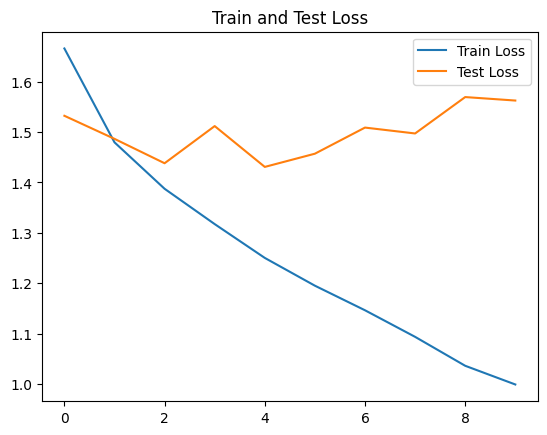

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.5294118].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84313726..0.85882354].


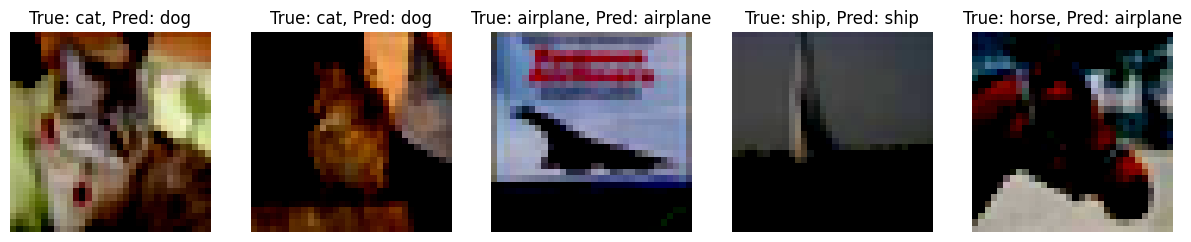

Model saved to models/SimpleCIFARNet__no_reg-e_10-lr_0.001__v1.0.0.pth


In [170]:
model = SimpleCIFARNet(tags='no_reg/e_10/lr_0.001')
model.init_datasets(train_dataset=train_dataset, test_dataset=test_dataset)
model.init_loaders(train_loader=train_loader, test_loader=test_loader)
model.train_model(epochs=10, lr=0.001)

model.save_model(version="1.0.0")

### З регуляризацією

Epoch 1/10, Train Loss: 1.6718, Test Loss: 1.5623, Accuracy: 0.4515
Epoch 2/10, Train Loss: 1.5255, Test Loss: 1.5071, Accuracy: 0.4670
Epoch 3/10, Train Loss: 1.4736, Test Loss: 1.4907, Accuracy: 0.4792
Epoch 4/10, Train Loss: 1.4369, Test Loss: 1.4536, Accuracy: 0.4898
Epoch 5/10, Train Loss: 1.4129, Test Loss: 1.4574, Accuracy: 0.4881
Epoch 6/10, Train Loss: 1.3892, Test Loss: 1.4657, Accuracy: 0.4851
Epoch 7/10, Train Loss: 1.3741, Test Loss: 1.4867, Accuracy: 0.4821
Epoch 8/10, Train Loss: 1.3608, Test Loss: 1.4482, Accuracy: 0.4928
Epoch 9/10, Train Loss: 1.3460, Test Loss: 1.4542, Accuracy: 0.4936
Epoch 10/10, Train Loss: 1.3387, Test Loss: 1.4627, Accuracy: 0.4900


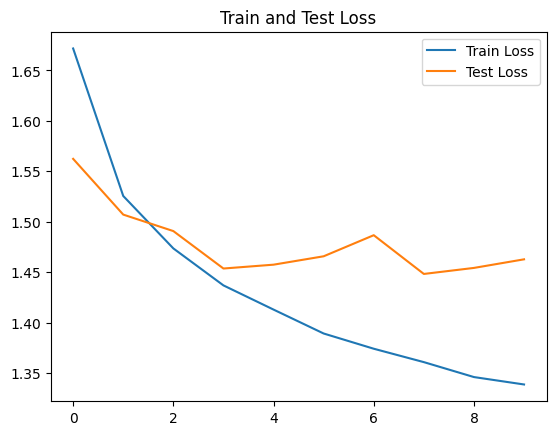

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8117647..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.62352943].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


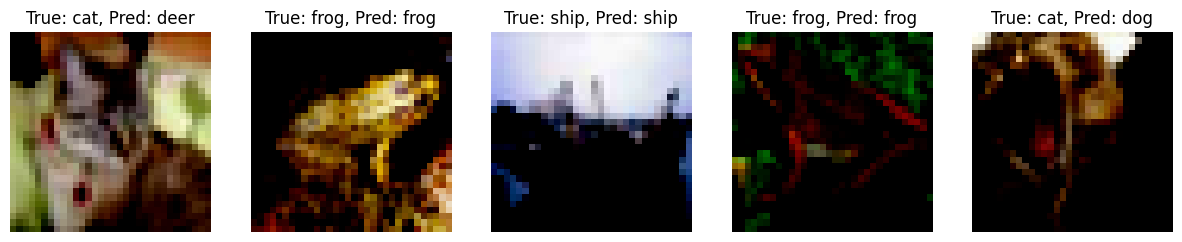

In [ ]:
model = SimpleCIFARNet(tags='reg/e_10/lr_0.001/wd_0.001')
model.init_datasets(train_dataset=train_dataset, test_dataset=test_dataset)
model.init_loaders(train_loader=train_loader, test_loader=test_loader)
model.train_model(epochs=10, lr=0.001, weight_decay=0.001)

model.save_model(version="1.0.0")

## CIFARNeuralNetWithDropout

### Без регуляризації

Epoch 1/15, Train Loss: 1.7475, Test Loss: 1.5552, Accuracy: 0.4547
Epoch 2/15, Train Loss: 1.5989, Test Loss: 1.4970, Accuracy: 0.4734
Epoch 3/15, Train Loss: 1.5346, Test Loss: 1.4625, Accuracy: 0.4885
Epoch 4/15, Train Loss: 1.4887, Test Loss: 1.4416, Accuracy: 0.4999
Epoch 5/15, Train Loss: 1.4591, Test Loss: 1.4200, Accuracy: 0.4966
Epoch 6/15, Train Loss: 1.4194, Test Loss: 1.4127, Accuracy: 0.4952
Epoch 7/15, Train Loss: 1.3850, Test Loss: 1.3958, Accuracy: 0.5064
Epoch 8/15, Train Loss: 1.3581, Test Loss: 1.3827, Accuracy: 0.5130
Epoch 9/15, Train Loss: 1.3424, Test Loss: 1.3620, Accuracy: 0.5204
Epoch 10/15, Train Loss: 1.3158, Test Loss: 1.3929, Accuracy: 0.5093
Epoch 11/15, Train Loss: 1.3009, Test Loss: 1.3566, Accuracy: 0.5238
Epoch 12/15, Train Loss: 1.2778, Test Loss: 1.3727, Accuracy: 0.5204
Epoch 13/15, Train Loss: 1.2602, Test Loss: 1.3690, Accuracy: 0.5265
Epoch 14/15, Train Loss: 1.2424, Test Loss: 1.3560, Accuracy: 0.5253
Epoch 15/15, Train Loss: 1.2249, Test Loss:

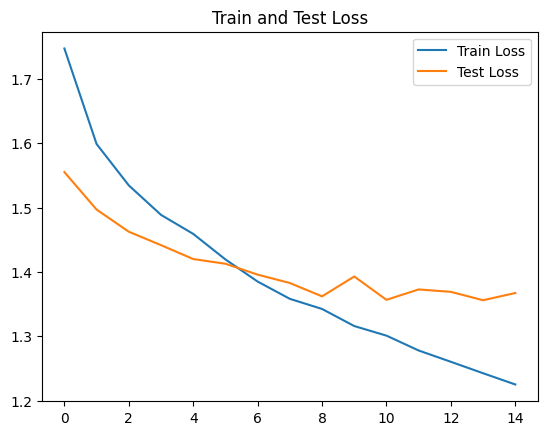

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.54509807..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75686276..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


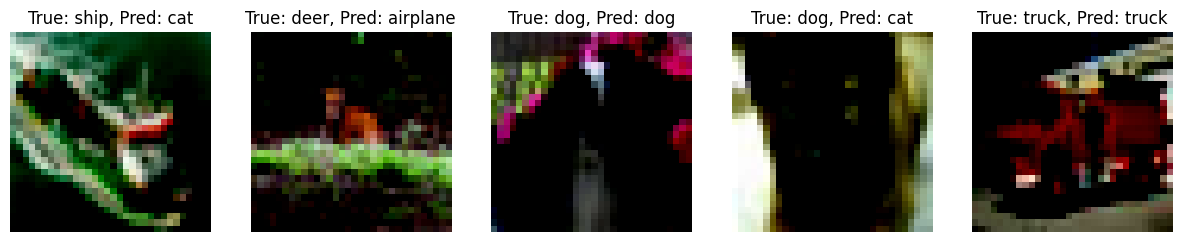

In [ ]:
model = CIFARNeuralNetWithDropout(tags="no_reg/e_15/lr_0.001/p_0.3", p_dropout=0.3)
model.init_datasets(train_dataset=train_dataset, test_dataset=test_dataset)
model.init_loaders(train_loader=train_loader, test_loader=test_loader)
model.train_model(epochs=15, lr=0.001)

model.save_model(version="1.0.0")

Epoch 1/20, Train Loss: 1.7846, Test Loss: 1.5785, Accuracy: 0.4466
Epoch 2/20, Train Loss: 1.5871, Test Loss: 1.5028, Accuracy: 0.4745
Epoch 3/20, Train Loss: 1.5054, Test Loss: 1.4397, Accuracy: 0.4933
Epoch 4/20, Train Loss: 1.4479, Test Loss: 1.4065, Accuracy: 0.5096
Epoch 5/20, Train Loss: 1.4018, Test Loss: 1.3658, Accuracy: 0.5190
Epoch 6/20, Train Loss: 1.3638, Test Loss: 1.3474, Accuracy: 0.5261
Epoch 7/20, Train Loss: 1.3329, Test Loss: 1.3303, Accuracy: 0.5328
Epoch 8/20, Train Loss: 1.2991, Test Loss: 1.3210, Accuracy: 0.5348
Epoch 9/20, Train Loss: 1.2691, Test Loss: 1.3105, Accuracy: 0.5394
Epoch 10/20, Train Loss: 1.2427, Test Loss: 1.2945, Accuracy: 0.5439
Epoch 11/20, Train Loss: 1.2134, Test Loss: 1.2829, Accuracy: 0.5483
Epoch 12/20, Train Loss: 1.1881, Test Loss: 1.2696, Accuracy: 0.5510
Epoch 13/20, Train Loss: 1.1695, Test Loss: 1.2632, Accuracy: 0.5522
Epoch 14/20, Train Loss: 1.1454, Test Loss: 1.2557, Accuracy: 0.5584
Epoch 15/20, Train Loss: 1.1265, Test Loss:

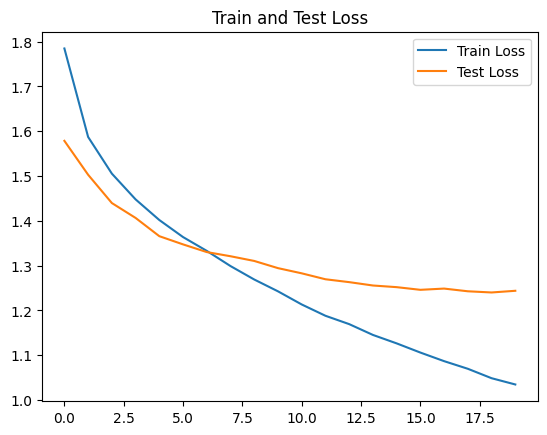

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75686276..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


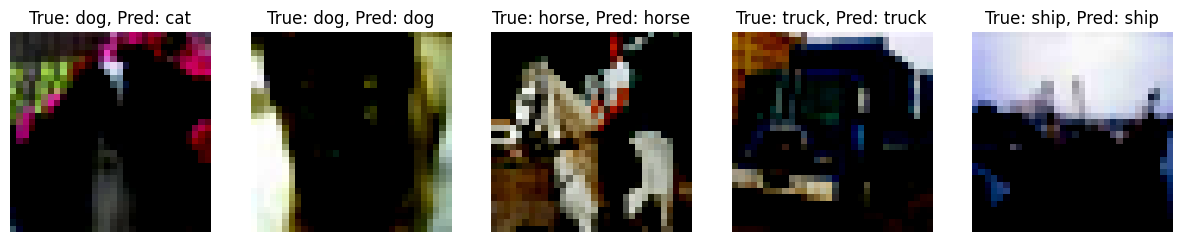

In [ ]:
model = CIFARNeuralNetWithDropout(tags="no_reg/e_20/lr_0.0001/p_0.3", p_dropout=0.3)
model.init_datasets(train_dataset=train_dataset, test_dataset=test_dataset)
model.init_loaders(train_loader=train_loader, test_loader=test_loader)
model.train_model(epochs=20, lr=0.0001)

model.save_model(version="1.0.0")

### З регуляризацією

Epoch 1/15, Train Loss: 1.8399, Test Loss: 1.7355, Accuracy: 0.3885
Epoch 2/15, Train Loss: 1.8035, Test Loss: 1.7419, Accuracy: 0.3790
Epoch 3/15, Train Loss: 1.7932, Test Loss: 1.7508, Accuracy: 0.3649
Epoch 4/15, Train Loss: 1.7858, Test Loss: 1.7403, Accuracy: 0.3732
Epoch 5/15, Train Loss: 1.7894, Test Loss: 1.7270, Accuracy: 0.3804
Epoch 6/15, Train Loss: 1.7785, Test Loss: 1.7274, Accuracy: 0.3819
Epoch 7/15, Train Loss: 1.7793, Test Loss: 1.7009, Accuracy: 0.3937
Epoch 8/15, Train Loss: 1.7766, Test Loss: 1.7289, Accuracy: 0.3810
Epoch 9/15, Train Loss: 1.7763, Test Loss: 1.6826, Accuracy: 0.4023
Epoch 10/15, Train Loss: 1.7773, Test Loss: 1.7047, Accuracy: 0.3830
Epoch 11/15, Train Loss: 1.7774, Test Loss: 1.6983, Accuracy: 0.3967
Epoch 12/15, Train Loss: 1.7731, Test Loss: 1.7085, Accuracy: 0.3841
Epoch 13/15, Train Loss: 1.7736, Test Loss: 1.7008, Accuracy: 0.3922
Epoch 14/15, Train Loss: 1.7735, Test Loss: 1.6892, Accuracy: 0.3904
Epoch 15/15, Train Loss: 1.7722, Test Loss:

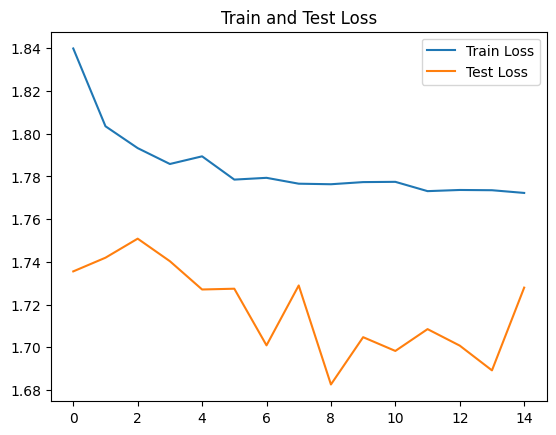

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.58431375].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.47450984].


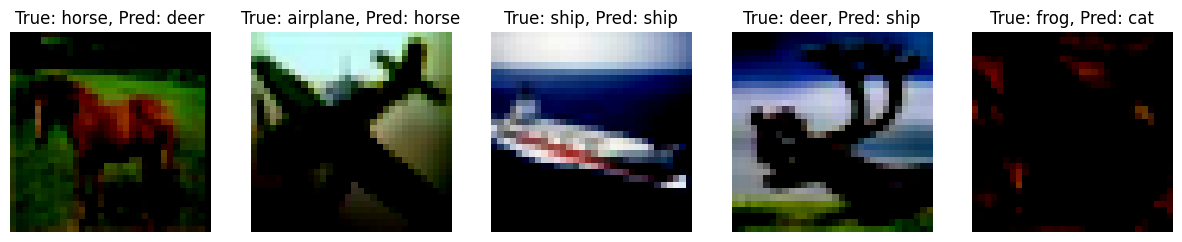

In [ ]:
model = CIFARNeuralNetWithDropout(tags="reg/e_15/lr_0.001/p_0.3/wd_0.01", p_dropout=0.3)
model.init_datasets(train_dataset=train_dataset, test_dataset=test_dataset)
model.init_loaders(train_loader=train_loader, test_loader=test_loader)
model.train_model(epochs=15, lr=0.001, weight_decay=0.01)

model.save_model(version="1.0.0")

Epoch 1/15, Train Loss: 1.8019, Test Loss: 1.6298, Accuracy: 0.4332
Epoch 2/15, Train Loss: 1.6356, Test Loss: 1.5775, Accuracy: 0.4433
Epoch 3/15, Train Loss: 1.5825, Test Loss: 1.5273, Accuracy: 0.4632
Epoch 4/15, Train Loss: 1.5462, Test Loss: 1.4990, Accuracy: 0.4795
Epoch 5/15, Train Loss: 1.5229, Test Loss: 1.4862, Accuracy: 0.4839
Epoch 6/15, Train Loss: 1.5081, Test Loss: 1.4667, Accuracy: 0.4917
Epoch 7/15, Train Loss: 1.4879, Test Loss: 1.4672, Accuracy: 0.4849
Epoch 8/15, Train Loss: 1.4773, Test Loss: 1.4402, Accuracy: 0.5021
Epoch 9/15, Train Loss: 1.4666, Test Loss: 1.4447, Accuracy: 0.4931
Epoch 10/15, Train Loss: 1.4548, Test Loss: 1.4253, Accuracy: 0.5005
Epoch 11/15, Train Loss: 1.4498, Test Loss: 1.4192, Accuracy: 0.5015
Epoch 12/15, Train Loss: 1.4448, Test Loss: 1.4084, Accuracy: 0.5061
Epoch 13/15, Train Loss: 1.4353, Test Loss: 1.4121, Accuracy: 0.5092
Epoch 14/15, Train Loss: 1.4295, Test Loss: 1.4068, Accuracy: 0.5094
Epoch 15/15, Train Loss: 1.4265, Test Loss:

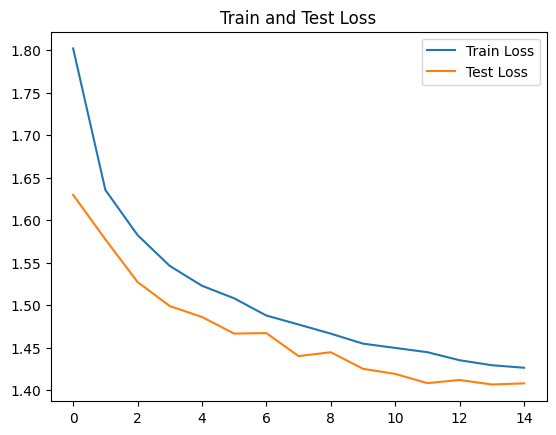

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.8980392].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.827451..0.827451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8039216..0.6784314].


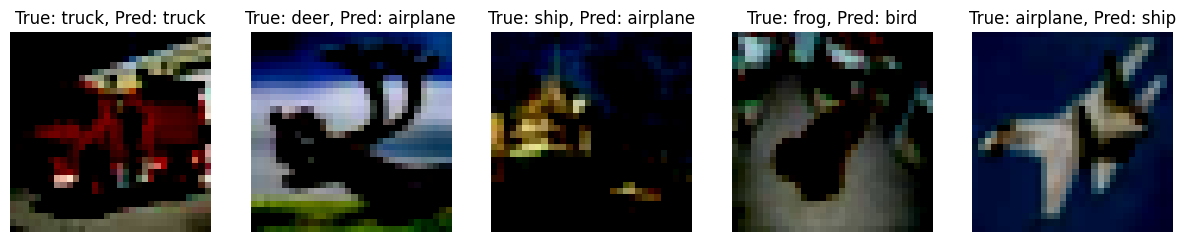

In [ ]:
model = CIFARNeuralNetWithDropout(tags="reg/e_15/lr_0.0001/p_0.3/wd_0.01", p_dropout=0.3)
model.init_datasets(train_dataset=train_dataset, test_dataset=test_dataset)
model.init_loaders(train_loader=train_loader, test_loader=test_loader)
model.train_model(epochs=15, lr=0.0001, weight_decay=0.01)

model.save_model(version="1.0.0")

## EnhancedCIFARNet

Epoch 1/25, Train Loss: 1.4298, Test Loss: 1.1590, Accuracy: 0.5960
Epoch 2/25, Train Loss: 1.0589, Test Loss: 0.9612, Accuracy: 0.6645
Epoch 3/25, Train Loss: 0.9318, Test Loss: 0.8891, Accuracy: 0.6931
Epoch 4/25, Train Loss: 0.8432, Test Loss: 0.8588, Accuracy: 0.7032
Epoch 5/25, Train Loss: 0.7751, Test Loss: 0.8018, Accuracy: 0.7164
Epoch 6/25, Train Loss: 0.7235, Test Loss: 0.7885, Accuracy: 0.7195
Epoch 7/25, Train Loss: 0.6699, Test Loss: 0.7764, Accuracy: 0.7295
Epoch 8/25, Train Loss: 0.6256, Test Loss: 0.7775, Accuracy: 0.7300
Epoch 9/25, Train Loss: 0.5885, Test Loss: 0.7275, Accuracy: 0.7432
Epoch 10/25, Train Loss: 0.5490, Test Loss: 0.7240, Accuracy: 0.7469
Epoch 11/25, Train Loss: 0.5144, Test Loss: 0.7709, Accuracy: 0.7362
Epoch 12/25, Train Loss: 0.4789, Test Loss: 0.7265, Accuracy: 0.7503
Epoch 13/25, Train Loss: 0.4473, Test Loss: 0.7658, Accuracy: 0.7396
Epoch 14/25, Train Loss: 0.4220, Test Loss: 0.7612, Accuracy: 0.7424
Epoch 15/25, Train Loss: 0.3906, Test Loss:

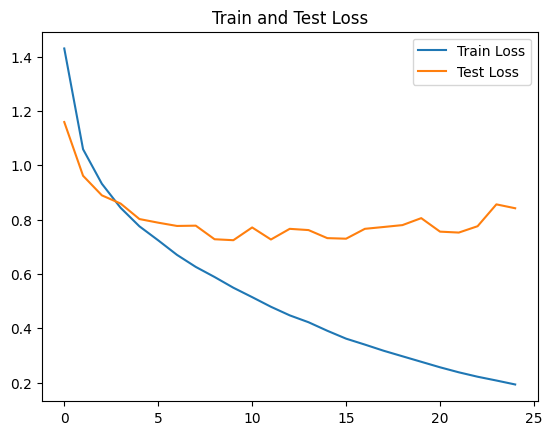

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.6156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].


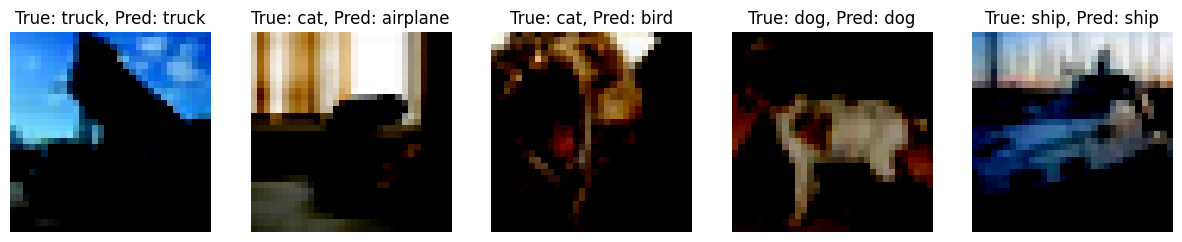

In [ ]:
model = EnhancedCIFARNet(tags="reg/e_25/lr_0.0001/p_0.3/wd_0.001",p_dropout=0.3)
model.init_datasets(train_dataset=train_dataset, test_dataset=test_dataset)
model.init_loaders(train_loader=train_loader, test_loader=test_loader)
model.train_model(epochs=25, lr=0.0001, weight_decay=0.001)

model.save_model(version="1.0.0")

### Покращення для моделі 

#### 1. Збільшення ширини та глибини моделі
Спробуємо збільшити кількість фільтрів у згорткових шарах:

In [183]:
class EnhancedCIFARNetWD(BaseNeuralNet):
    def __init__(self, tags, p_dropout=0.3):
        super(EnhancedCIFARNetWD, self).__init__(tags)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Додавання нормалізації та Dropout
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.dropout = nn.Dropout(p=p_dropout)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

        # Визначаємо розмірність після згорткових і пулингових шарів
        test_tensor = torch.zeros(1, 3, 32, 32)  # Подаємо фейковий вхід
        out = self.pool(self.relu(self.batch_norm1(self.conv1(test_tensor))))
        out = self.pool(self.relu(self.batch_norm2(self.conv2(out))))
        out = self.pool(self.relu(self.batch_norm3(self.conv3(out))))
        flatten_size = out.view(-1).shape[0]

        # Лінійні шари
        self.fc1 = nn.Linear(flatten_size, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(self.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(self.relu(self.batch_norm3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Перетворення в 1D
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.softmax(self.fc2(x))
        return x


Epoch 1/25, Train Loss: 1.2625, Test Loss: 0.9840, Accuracy: 0.6550
Epoch 2/25, Train Loss: 0.9054, Test Loss: 0.8418, Accuracy: 0.7074
Epoch 3/25, Train Loss: 0.7676, Test Loss: 0.7872, Accuracy: 0.7309
Epoch 4/25, Train Loss: 0.6762, Test Loss: 0.7004, Accuracy: 0.7590
Epoch 5/25, Train Loss: 0.5987, Test Loss: 0.6890, Accuracy: 0.7607
Epoch 6/25, Train Loss: 0.5334, Test Loss: 0.6635, Accuracy: 0.7730
Epoch 7/25, Train Loss: 0.4714, Test Loss: 0.7026, Accuracy: 0.7587
Epoch 8/25, Train Loss: 0.4142, Test Loss: 0.6778, Accuracy: 0.7702
Epoch 9/25, Train Loss: 0.3624, Test Loss: 0.6652, Accuracy: 0.7767
Epoch 10/25, Train Loss: 0.3157, Test Loss: 0.7210, Accuracy: 0.7687
Epoch 11/25, Train Loss: 0.2719, Test Loss: 0.7017, Accuracy: 0.7741
Epoch 12/25, Train Loss: 0.2332, Test Loss: 0.7028, Accuracy: 0.7808
Epoch 13/25, Train Loss: 0.1984, Test Loss: 0.6551, Accuracy: 0.7941
Epoch 14/25, Train Loss: 0.1696, Test Loss: 0.7114, Accuracy: 0.7796
Epoch 15/25, Train Loss: 0.1511, Test Loss:

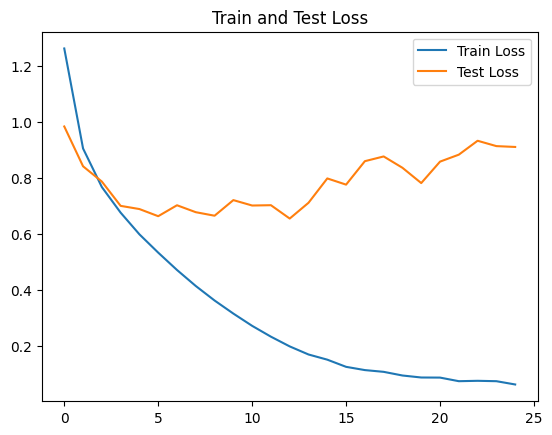

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8352941..0.58431375].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


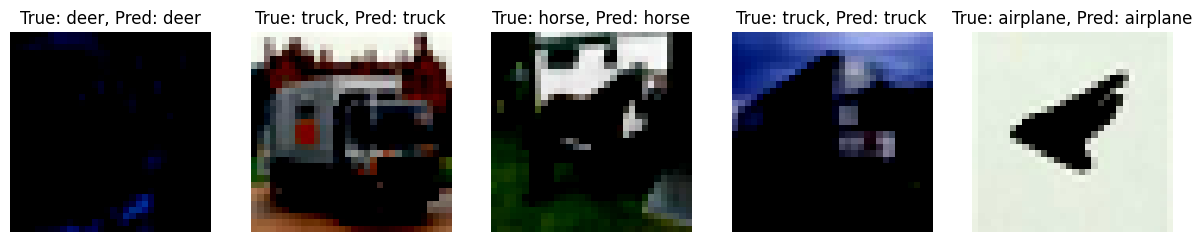

In [ ]:
model = EnhancedCIFARNetWD(tags="reg/e_25/lr_0.0001/p_0.3/wd_0.001", p_dropout=0.3)
model.init_datasets(train_dataset=train_dataset, test_dataset=test_dataset)
model.init_loaders(train_loader=train_loader, test_loader=test_loader)
model.train_model(epochs=25, lr=0.0001, weight_decay=0.001)

model.save_model(version="1.0.0")

#### 2. Аугментація даних


+ transforms.RandomCrop(32, padding=4),
+ transforms.RandomHorizontalFlip(),

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/25, Train Loss: 1.4667, Test Loss: 1.0971, Accuracy: 0.6100
Epoch 2/25, Train Loss: 1.1299, Test Loss: 0.9383, Accuracy: 0.6718
Epoch 3/25, Train Loss: 0.9982, Test Loss: 0.8402, Accuracy: 0.7095
Epoch 4/25, Train Loss: 0.9179, Test Loss: 0.8486, Accuracy: 0.6975
Epoch 5/25, Train Loss: 0.8604, Test Loss: 0.7915, Accuracy: 0.7221
Epoch 6/25, Train Loss: 0.8132, Test Loss: 0.7098, Accuracy: 0.7471
Epoch 7/25, Train Loss: 0.7815, Test Loss: 0.6976, Accuracy: 0.7556
Epoch 8/25, Train Loss: 0.7452, Test Loss: 0.6890, Accuracy: 0.7599
Epoch 9/25, Train Loss: 0.7183, Test Loss: 0.6687, Accuracy: 0.7656
Epoch 10/25, Train Loss: 0.6899, Test Loss: 0.7115, Accuracy: 0.7475
Epoch 11/25, Train Loss: 0.6729, Test Loss: 0.6451, Accuracy: 0.7724
Epoch 12/25, Train Loss: 0.6522, Test Loss: 0.5945, Accuracy: 0.7961
Epoch 13/25, Train Loss: 0.6348, Test Loss: 0.5988, Accuracy: 0.7914
Epoch 14/25, Train Loss: 0.6272, Tes

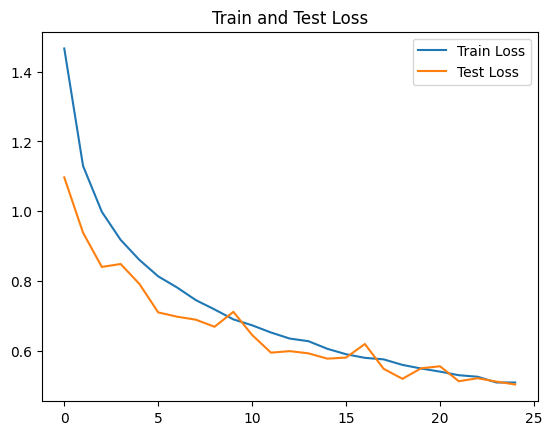

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8352941..0.58431375].


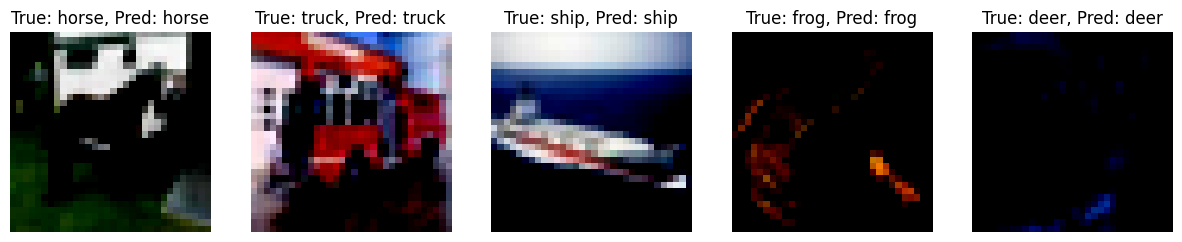

Model saved to models/EnhancedCIFARNetWD__reg-e_25-lr_0.0001-p_0.3-wd_0.001-arg__v1.0.0.pth


In [178]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = EnhancedCIFARNetWD(tags="reg/e_25/lr_0.0001/p_0.3/wd_0.001/arg", p_dropout=0.3)
model.init_datasets(train_dataset=train_dataset, test_dataset=test_dataset)
model.init_loaders(train_loader=train_loader, test_loader=test_loader)
model.train_model(epochs=25, lr=0.0001, weight_decay=0.001)

model.save_model(version="1.0.0")

transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/25, Train Loss: 1.5448, Test Loss: 1.1351, Accuracy: 0.5968
Epoch 2/25, Train Loss: 1.2062, Test Loss: 0.9675, Accuracy: 0.6604
Epoch 3/25, Train Loss: 1.0824, Test Loss: 0.8885, Accuracy: 0.6841
Epoch 4/25, Train Loss: 1.0047, Test Loss: 0.8446, Accuracy: 0.7078
Epoch 5/25, Train Loss: 0.9397, Test Loss: 0.7897, Accuracy: 0.7246
Epoch 6/25, Train Loss: 0.9023, Test Loss: 0.7847, Accuracy: 0.7281
Epoch 7/25, Train Loss: 0.8557, Test Loss: 0.7199, Accuracy: 0.7504
Epoch 8/25, Train Loss: 0.8205, Test Loss: 0.7181, Accuracy: 0.7471
Epoch 9/25, Train Loss: 0.7984, Test Loss: 0.6831, Accuracy: 0.7640
Epoch 10/25, Train Loss: 0.7702, Test Loss: 0.6732, Accuracy: 0.7651
Epoch 11/25, Train Loss: 0.7526, Test Loss: 0.6845, Accuracy: 0.7639
Epoch 12/25, Train Loss: 0.7321, Test Loss: 0.6262, Accuracy: 0.7801
Epoch 13/25, Train Loss: 0.7185, Test Loss: 0.6331, Accuracy: 0.7821
Epoch 14/25, Train Loss: 0.7009, Tes

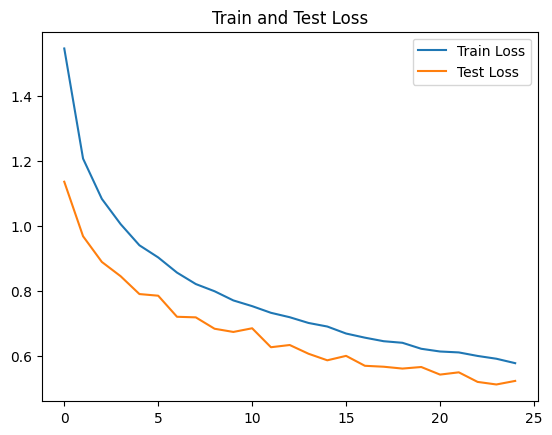

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79607844..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.8745098].


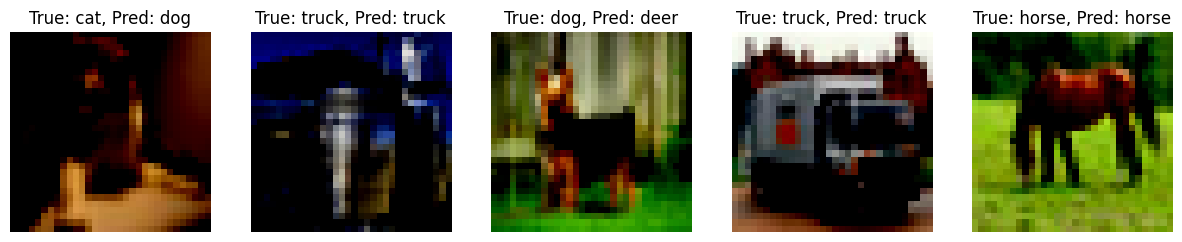

In [ ]:
transform_train = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = EnhancedCIFARNetWD(tags="reg/e_25/lr_0.0001/p_0.3/wd_0.001/arg_cj", p_dropout=0.3)
model.init_datasets(train_dataset=train_dataset, test_dataset=test_dataset)
model.init_loaders(train_loader=train_loader, test_loader=test_loader)
model.train_model(epochs=25, lr=0.0001, weight_decay=0.001)

model.save_model(version="1.0.0")

### Додавано можливість ранньої зупинки (Early Stopping)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/25, Train Loss: 1.5383, Test Loss: 1.1343, Accuracy: 0.5928
Epoch 2/25, Train Loss: 1.2020, Test Loss: 0.9960, Accuracy: 0.6510
Epoch 3/25, Train Loss: 1.0683, Test Loss: 0.9017, Accuracy: 0.6823
Epoch 4/25, Train Loss: 0.9885, Test Loss: 0.8170, Accuracy: 0.7154
Epoch 5/25, Train Loss: 0.9280, Test Loss: 0.7700, Accuracy: 0.7337
Epoch 6/25, Train Loss: 0.8826, Test Loss: 0.7403, Accuracy: 0.7351
Epoch 7/25, Train Loss: 0.8412, Test Loss: 0.7177, Accuracy: 0.7461
Epoch 8/25, Train Loss: 0.8130, Test Loss: 0.6881, Accuracy: 0.7567
Epoch 9/25, Train Loss: 0.7855, Test Loss: 0.6953, Accuracy: 0.7590
Epoch 10/25, Train Loss: 0.7592, Test Loss: 0.6973, Accuracy: 0.7542
Epoch 11/25, Train Loss: 0.7436, Test Loss: 0.6450, Accuracy: 0.7766
Epoch 12/25, Train Loss: 0.7218, Test Loss: 0.6352, Accuracy: 0.7767
Epoch 13/25, Train Loss: 0.7017, Test Loss: 0.6274, Accuracy: 0.7811
Epoch 14/25, Train Loss: 0.6849, Tes

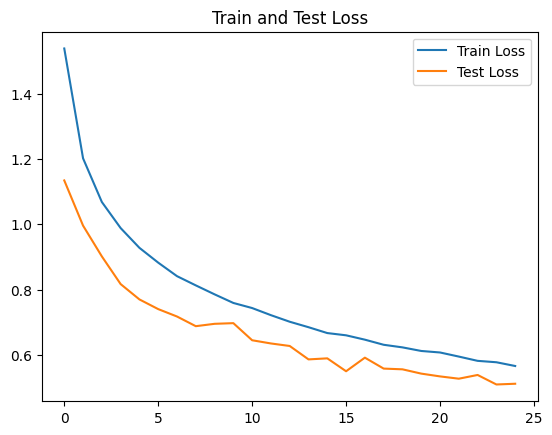

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.654902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84313726..0.96862745].


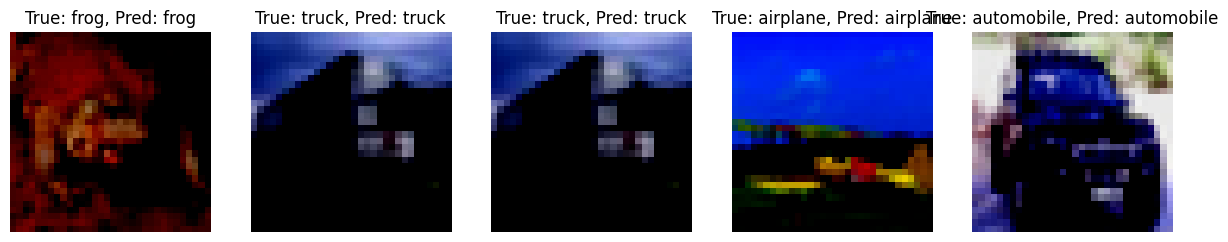

Model saved to models/EnhancedCIFARNetWD__reg-e_25-lr_0.0001-p_0.3-wd_0.001-arg_cj-es=5__v1.0.0.pth


In [184]:
transform_train = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = EnhancedCIFARNetWD(tags="reg/e_25/lr_0.0001/p_0.3/wd_0.001/arg_cj/es=5", p_dropout=0.3)
model.init_datasets(train_dataset=train_dataset, test_dataset=test_dataset)
model.init_loaders(train_loader=train_loader, test_loader=test_loader)
model.train_model(epochs=25, lr=0.0001, weight_decay=0.001, early_stopping_patience=5)

model.save_model(version="1.0.0")